In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


#enable IPython to display matplolib graphs
%matplotlib inline

from sklearn import tree


In [2]:
from ML_classes.DTModel import DTModel
from ML_classes.LinearModel import LinearModel
from ML_classes.LSTMModel import LSTMModel
from ML_classes.MLPModel import MLPModel



2022-03-29 08:11:20.811189: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-29 08:11:20.811231: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
weather_data = pd.read_csv("./data/weather_hourly_darksky.csv")
weather_data["time"] = pd.to_datetime(weather_data["time"])
weather_data["temperature"] = pd.to_numeric(weather_data["temperature"], downcast="float", errors="coerce")
weather_data["temperature"] = weather_data["temperature"] **2


In [4]:
weather_data["temperature"]

0        104.857597
1         95.257607
2         89.491600
3         85.192894
4         85.747604
            ...    
21160     54.612099
21161     43.033600
21162     41.860897
21163     35.521599
21164     28.944401
Name: temperature, Length: 21165, dtype: float32

In [5]:
#if we are to interpolate temperature for halfhour

In [6]:
df = pd.read_csv('./data/ouput.csv')
df['tstp'] = [datetime.strptime(x, '%Y-%m-%d %H:%M:%S') for x in df['tstp']]
#df["tstp"] = pd.to_datetime(df["tstp"])
df["energy(kWh/hh)"] = pd.to_numeric(df["energy(kWh/hh)"], downcast="float", errors="coerce")


In [7]:
houses_with_temperature_correlation = ["MAC000150","MAC000153","MAC000168","MAC000169","MAC000173"]

In [8]:
#for singular house testing
lclid_list = df['LCLid'].unique()
def find_household(identification):
    affluenthh_filt = df["LCLid"] == identification
    affluent_hh_data = df[affluenthh_filt]
    return affluent_hh_data

hh = find_household("MAC000153")
hh.pop("LCLid")

#making data hourly or not
hh = hh.set_index("tstp")
hh = hh.resample("H").sum()
hh = hh.reset_index()

#use of weather data
weather_set = weather_data.set_index("time")
weather_set = weather_set[str(hh["tstp"].min()):str(hh["tstp"].max())]
weather_set = weather_set.reset_index()
hh["temperature"] = weather_set["temperature"]
# weather data doesnt necessarily contain data for all dates
hh.dropna(axis=0,how='any',subset=["temperature"], inplace=True)

hh_max = hh['energy(kWh/hh)'].max()
hh['energy(kWh/hh)'] = hh['energy(kWh/hh)'].apply(lambda x: x / hh_max)
hh['temperature'] = hh['temperature'].apply(lambda x: x / hh['temperature'].max())

In [9]:
## DT
#train for all houses
#lclid_list = df['LCLid'].unique().tolist()
#print(type(lclid_list))
mse = []
rmse = []
mae = []
mape = []
for lclid in houses_with_temperature_correlation :
    #print(lclid)


    hh = find_household(lclid)
    hh.pop("LCLid")
    #hourly
    hh = hh.set_index("tstp")
    hh = hh.resample("H").sum()
    hh = hh.reset_index()
    
    #use of weather data
    weather_set = weather_data.set_index("time")
    weather_set = weather_set[str(hh["tstp"].min()):str(hh["tstp"].max())]
    weather_set = weather_set.reset_index()
    hh["temperature"] = weather_set["temperature"]
    # weather data doesnt necessarily contain data for all dates
    hh.dropna(axis=0,how='any',subset=["temperature"], inplace=True)

    #normalization
    hh_max = hh['energy(kWh/hh)'].max()
    hh['energy(kWh/hh)'] = hh['energy(kWh/hh)'].apply(lambda x: x / hh_max)
    hh['temperature'] = hh['temperature'].apply(lambda x: x / hh['temperature'].max())
    
    
    # Initiating the class
    DT = DTModel(
    data = hh,
    Y_var = 'energy(kWh/hh)',
    lag = 24,
    epochs = 20,
    batch_size = 256,
    train_test_split = 0.15,
    data_creator= "temperature"
    )
    #training
    DT.DTModel()
    
    mse.append(DT.eval.MSE())
    rmse.append(DT.eval.RMSE())
    mae.append(DT.eval.MAE())
    mape.append(DT.eval.MAPE())
houses = pd.Series(data=houses_with_temperature_correlation,name="lclid")
mse = pd.Series(data=mse,name="mse")
rmse = pd.Series(data=rmse,name="rmse")
mae = pd.Series(data=mae,name="mae")
mape = pd.Series(data=mape,name="mape")

res_df = pd.merge(houses, mse, right_index=True, left_index=True)
res_df["rmse"] = rmse
res_df["mae"] = mae
res_df["mape"] = mape

res_df

,lclid,mse,rmse,mae,mape
0,MAC000150,0.014311,0.119629,0.067304,73.807111
1,MAC000153,0.011837,0.108798,0.073633,54.535432
2,MAC000168,0.010134,0.100669,0.039735,130.590258
3,MAC000169,0.008443,0.091886,0.054705,73.593677
4,MAC000173,0.015714,0.125355,0.076696,50.556915


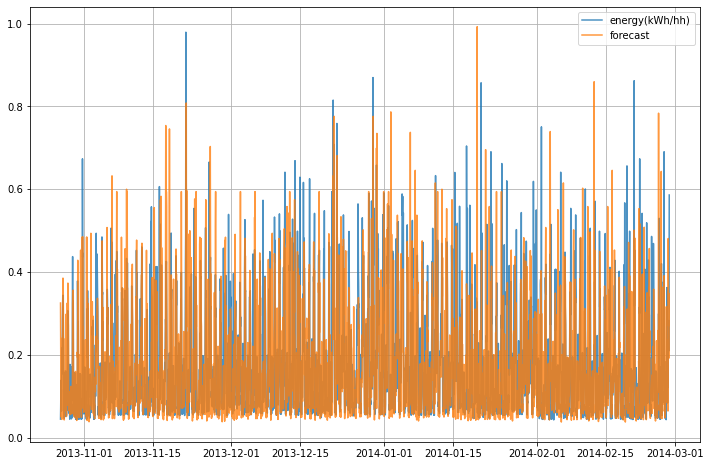

In [10]:
# Defining the lag that we used for training of the model 
lag_model = 24
# Getting the last period
ts = hh['energy(kWh/hh)'].tail(lag_model).values.tolist()
# Creating the X matrix for the model
#X, _ = DT.dc.create_X_Y(ts, lag=lag_model)

#for time values
tlist = hh['temperature'].tail(lag_model).values.tolist()
#print(tlist)
X, _ = DT.dc.create_X_Y(ts, tlist, lag=lag_model)
#print(X)

X = DT.alter_x_shape(X)
# Getting the forecast
yhat = DT.model.predict(X)

yhat = DT.predict()
# Constructing the forecast dataframe
fc = hh.tail(len(yhat)).copy()
fc.reset_index(inplace=True)
fc['forecast'] = yhat
# Ploting the forecasts
plt.figure(figsize=(12, 8))
for dtype in ['energy(kWh/hh)', 'forecast']:
  plt.plot(
    'tstp',
    dtype,
    data=fc,
    label=dtype,
    alpha=0.8
  )
plt.legend()
plt.grid()

In [11]:
## perceptron
#train for all houses
#lclid_list = df['LCLid'].unique().tolist()
#print(type(lclid_list))
mse = []
rmse = []
mae = []
mape = []
for lclid in houses_with_temperature_correlation :
    #print(lclid)


    hh = find_household(lclid)
    hh.pop("LCLid")
    #hourly
    hh = hh.set_index("tstp")
    hh = hh.resample("H").sum()
    hh = hh.reset_index()
    
    #use of weather data
    weather_set = weather_data.set_index("time")
    weather_set = weather_set[str(hh["tstp"].min()):str(hh["tstp"].max())]
    weather_set = weather_set.reset_index()
    hh["temperature"] = weather_set["temperature"]
    # weather data doesnt necessarily contain data for all dates
    hh.dropna(axis=0,how='any',subset=["temperature"], inplace=True)

    #normalization
    hh_max = hh['energy(kWh/hh)'].max()
    hh['energy(kWh/hh)'] = hh['energy(kWh/hh)'].apply(lambda x: x / hh_max)
    hh['temperature'] = hh['temperature'].apply(lambda x: x /hh['temperature'].max())
    
    
    # Initiating the class
    Linear = LinearModel(
    data = hh,
    Y_var = 'energy(kWh/hh)',
    lag = 24,
    epochs = 20,
    batch_size = 256,
    train_test_split = 0.15,
    data_creator= "temperature"
    )
    #training
    Linear.LinearModel()
    
    mse.append(Linear.eval.MSE())
    rmse.append(Linear.eval.RMSE())
    mae.append(Linear.eval.MAE())
    mape.append(Linear.eval.MAPE())
houses = pd.Series(data=houses_with_temperature_correlation,name="lclid")
mse = pd.Series(data=mse,name="mse")
rmse = pd.Series(data=rmse,name="rmse")
mae = pd.Series(data=mae,name="mae")
mape = pd.Series(data=mape,name="mape")

res_df = pd.merge(houses, mse, right_index=True, left_index=True)
res_df["rmse"] = rmse
res_df["mae"] = mae
res_df["mape"] = mape



Epoch 1/20


2022-03-29 08:11:49.660157: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-29 08:11:49.660451: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-29 08:11:49.660506: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-03-29 08:11:49.660556: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-03-29 08:11:49.660605: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

66/66 [==============================] - 0s 2ms/step - loss: 3677.3777 - val_loss: 2143.3015
Epoch 2/20
66/66 [==============================] - 0s 961us/step - loss: 1670.5056 - val_loss: 1112.3606
Epoch 3/20
66/66 [==============================] - 0s 976us/step - loss: 896.6124 - val_loss: 667.0083
Epoch 4/20
66/66 [==============================] - 0s 914us/step - loss: 560.9459 - val_loss: 459.5087
Epoch 5/20
66/66 [==============================] - 0s 930us/step - loss: 396.4094 - val_loss: 345.7184
Epoch 6/20
66/66 [==============================] - 0s 1ms/step - loss: 302.6737 - val_loss: 275.3753
Epoch 7/20
66/66 [==============================] - 0s 982us/step - loss: 243.7809 - val_loss: 228.5540
Epoch 8/20
66/66 [==============================] - 0s 929us/step - loss: 204.0096 - val_loss: 195.2307
Epoch 9/20
66/66 [==============================] - 0s 1ms/step - loss: 175.2105 - val_loss: 169.9338
Epoch 10/20
66/66 [==============================] - 0s 921us/step - loss: 15

66/66 [==============================] - 0s 1ms/step - loss: 393.3949 - val_loss: 390.3299
Epoch 20/20
66/66 [==============================] - 0s 919us/step - loss: 368.8315 - val_loss: 367.5846
Epoch 1/20
66/66 [==============================] - 0s 2ms/step - loss: 17917.9805 - val_loss: 8734.8916
Epoch 2/20
66/66 [==============================] - 0s 930us/step - loss: 4835.7017 - val_loss: 2424.4722
Epoch 3/20
66/66 [==============================] - 0s 903us/step - loss: 1593.3514 - val_loss: 1048.8125
Epoch 4/20
66/66 [==============================] - 0s 896us/step - loss: 900.0908 - val_loss: 721.5366
Epoch 5/20
66/66 [==============================] - 0s 952us/step - loss: 677.7028 - val_loss: 577.8335
Epoch 6/20
66/66 [==============================] - 0s 897us/step - loss: 551.6752 - val_loss: 484.6247
Epoch 7/20
66/66 [==============================] - 0s 895us/step - loss: 463.8728 - val_loss: 417.0471
Epoch 8/20
66/66 [==============================] - 0s 907us/step - los

In [12]:
res_df

,lclid,mse,rmse,mae,mape
0,MAC000150,46.621912,6.828024,4.153726,1480.512064
1,MAC000153,164.097937,12.810072,7.669659,894.615571
2,MAC000168,302.550761,17.393986,10.132634,30988.107132
3,MAC000169,367.584609,19.172496,12.041527,6641.800581
4,MAC000173,179.665551,13.403938,7.831978,4953.988370


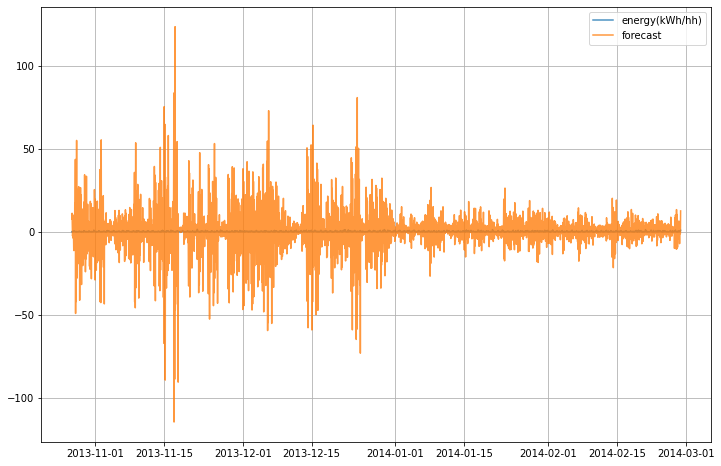

In [13]:
# Defining the lag that we used for training of the model 
lag_model = 24
# Getting the last period
ts = hh['energy(kWh/hh)'].tail(lag_model).values.tolist()
# Creating the X matrix for the model
#X, _ = DT.dc.create_X_Y(ts, lag=lag_model)

#for time values
tlist = hh['temperature'].tail(lag_model).values.tolist()
#print(tlist)
X, _ = Linear.dc.create_X_Y(ts, tlist, lag=lag_model)
#print(X)

#X = DT.alter_x_shape(X)
# Getting the forecast
yhat = Linear.model.predict(X)

yhat = Linear.predict()
# Constructing the forecast dataframe
fc = hh.tail(len(yhat)).copy()
fc.reset_index(inplace=True)
fc['forecast'] = yhat
# Ploting the forecasts
plt.figure(figsize=(12, 8))
for dtype in ['energy(kWh/hh)', 'forecast']:
  plt.plot(
    'tstp',
    dtype,
    data=fc,
    label=dtype,
    alpha=0.8
  )
plt.legend()
plt.grid()

In [14]:
## SLP
#train for all houses
#lclid_list = df['LCLid'].unique().tolist()
#print(type(lclid_list))
mse = []
rmse = []
mae = []
mape = []
for lclid in houses_with_temperature_correlation :
    #print(lclid)


    hh = find_household(lclid)
    hh.pop("LCLid")
    #hourly
    hh = hh.set_index("tstp")
    hh = hh.resample("H").sum()
    hh = hh.reset_index()
    
    #use of weather data
    weather_set = weather_data.set_index("time")
    weather_set = weather_set[str(hh["tstp"].min()):str(hh["tstp"].max())]
    weather_set = weather_set.reset_index()
    hh["temperature"] = weather_set["temperature"]
    # weather data doesnt necessarily contain data for all dates
    hh.dropna(axis=0,how='any',subset=["temperature"], inplace=True)

    #normalization
    hh_max = hh['energy(kWh/hh)'].max()
    hh['energy(kWh/hh)'] = hh['energy(kWh/hh)'].apply(lambda x: x / hh_max)
    hh['temperature'] = hh['temperature'].apply(lambda x: x / hh['temperature'].max())
    
    
    # Initiating the class
    MLP = MLPModel(
    data = hh,
    Y_var = 'energy(kWh/hh)',
    lag = 24,
    layer_depths = [30],
    layer_count = 1,
    epochs = 20,
    batch_size = 256,
    train_test_split = 0.15,
    data_creator= "temperature"
    )
    #training
    MLP.MLPModel()
    
    mse.append(MLP.eval.MSE())
    rmse.append(MLP.eval.RMSE())
    mae.append(MLP.eval.MAE())
    mape.append(MLP.eval.MAPE())
houses = pd.Series(data=houses_with_temperature_correlation,name="lclid")
mse = pd.Series(data=mse,name="mse")
rmse = pd.Series(data=rmse,name="rmse")
mae = pd.Series(data=mae,name="mae")
mape = pd.Series(data=mape,name="mape")

res_df = pd.merge(houses, mse, right_index=True, left_index=True)
res_df["rmse"] = rmse
res_df["mae"] = mae
res_df["mape"] = mape



Epoch 1/20
66/66 [==============================] - 0s 2ms/step - loss: 0.0113 - val_loss: 0.0084
Epoch 2/20
66/66 [==============================] - 0s 1ms/step - loss: 0.0070 - val_loss: 0.0067
Epoch 3/20
66/66 [==============================] - 0s 1ms/step - loss: 0.0061 - val_loss: 0.0061
Epoch 4/20
66/66 [==============================] - 0s 1ms/step - loss: 0.0057 - val_loss: 0.0058
Epoch 5/20
66/66 [==============================] - 0s 1ms/step - loss: 0.0055 - val_loss: 0.0057
Epoch 6/20
66/66 [==============================] - 0s 1ms/step - loss: 0.0054 - val_loss: 0.0056
Epoch 7/20
66/66 [==============================] - 0s 1ms/step - loss: 0.0054 - val_loss: 0.0056
Epoch 8/20
66/66 [==============================] - 0s 1ms/step - loss: 0.0053 - val_loss: 0.0056
Epoch 9/20
66/66 [==============================] - 0s 1ms/step - loss: 0.0053 - val_loss: 0.0055
Epoch 10/20
66/66 [==============================] - 0s 1ms/step - loss: 0.0052 - val_loss: 0.0055
Epoch 11/20
66/66 [

66/66 [==============================] - 0s 1ms/step - loss: 0.0082 - val_loss: 0.0100
Epoch 5/20
66/66 [==============================] - 0s 1ms/step - loss: 0.0079 - val_loss: 0.0098
Epoch 6/20
66/66 [==============================] - 0s 1ms/step - loss: 0.0077 - val_loss: 0.0096
Epoch 7/20
66/66 [==============================] - 0s 1ms/step - loss: 0.0076 - val_loss: 0.0095
Epoch 8/20
66/66 [==============================] - 0s 1ms/step - loss: 0.0075 - val_loss: 0.0094
Epoch 9/20
66/66 [==============================] - 0s 1ms/step - loss: 0.0075 - val_loss: 0.0094
Epoch 10/20
66/66 [==============================] - 0s 1ms/step - loss: 0.0074 - val_loss: 0.0093
Epoch 11/20
66/66 [==============================] - 0s 1ms/step - loss: 0.0074 - val_loss: 0.0093
Epoch 12/20
66/66 [==============================] - 0s 1ms/step - loss: 0.0074 - val_loss: 0.0092
Epoch 13/20
66/66 [==============================] - 0s 1ms/step - loss: 0.0073 - val_loss: 0.0092
Epoch 14/20
66/66 [========

In [15]:
res_df

,lclid,mse,rmse,mae,mape
0,MAC000150,0.005383,0.073370,0.044226,49.404314
1,MAC000153,0.007788,0.088247,0.061317,38.746215
2,MAC000168,0.005096,0.071387,0.033657,122.299750
3,MAC000169,0.004384,0.066210,0.039566,51.539977
4,MAC000173,0.009044,0.095099,0.060241,40.610706


In [16]:
MLP.model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 30)                1470      
                                                                 
 dense_14 (Dense)            (None, 1)                 31        
                                                                 
Total params: 1,501
Trainable params: 1,501
Non-trainable params: 0
_________________________________________________________________


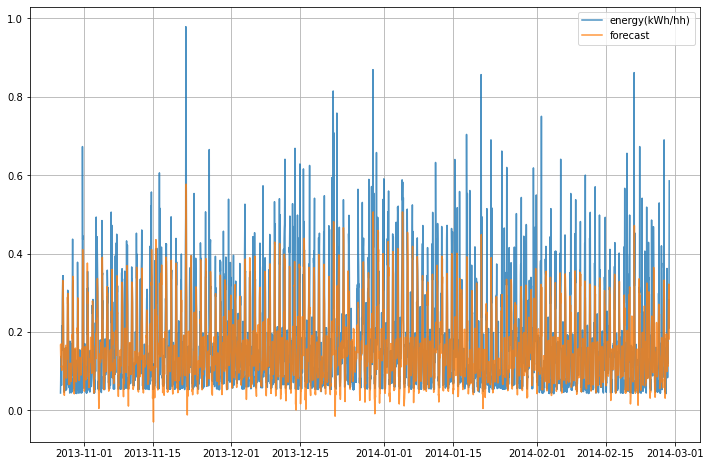

In [17]:
# Defining the lag that we used for training of the model 
lag_model = 24
# Getting the last period
ts = hh['energy(kWh/hh)'].tail(lag_model).values.tolist()
# Creating the X matrix for the model
#X, _ = DT.dc.create_X_Y(ts, lag=lag_model)

#for time values
tlist = hh['temperature'].tail(lag_model).values.tolist()
#print(tlist)
X, _ = MLP.dc.create_X_Y(ts, tlist, lag=lag_model)
#print(X)

# Getting the forecast
yhat = MLP.model.predict(X)

yhat = MLP.predict()
# Constructing the forecast dataframe
fc = hh.tail(len(yhat)).copy()
fc.reset_index(inplace=True)
fc['forecast'] = yhat
# Ploting the forecasts
plt.figure(figsize=(12, 8))
for dtype in ['energy(kWh/hh)', 'forecast']:
  plt.plot(
    'tstp',
    dtype,
    data=fc,
    label=dtype,
    alpha=0.8
  )
plt.legend()
plt.grid()

In [18]:
## SLP
#train for all houses
#lclid_list = df['LCLid'].unique().tolist()
#print(type(lclid_list))
mse = []
rmse = []
mae = []
mape = []
for lclid in houses_with_temperature_correlation :
    #print(lclid)


    hh = find_household(lclid)
    hh.pop("LCLid")
    #hourly
    hh = hh.set_index("tstp")
    hh = hh.resample("H").sum()
    hh = hh.reset_index()
    
    #use of weather data
    weather_set = weather_data.set_index("time")
    weather_set = weather_set[str(hh["tstp"].min()):str(hh["tstp"].max())]
    weather_set = weather_set.reset_index()
    hh["temperature"] = weather_set["temperature"]
    # weather data doesnt necessarily contain data for all dates
    hh.dropna(axis=0,how='any',subset=["temperature"], inplace=True)

    #normalization
    hh_max = hh['energy(kWh/hh)'].max()
    hh['energy(kWh/hh)'] = hh['energy(kWh/hh)'].apply(lambda x: x / hh_max)
    hh['temperature'] = hh['temperature'].apply(lambda x: x / hh['temperature'].max())
    
    
    # Initiating the class
    LSTM = LSTMModel(
    data = hh,
    Y_var = 'energy(kWh/hh)',
    lag = 24,
    LSTM_layer_depth = 50,
    epochs = 20,
    batch_size = 256,
    train_test_split = 0.15,
    data_creator= "temperature"
    )
    #training
    LSTM.LSTModel()
    
    mse.append(LSTM.eval.MSE())
    rmse.append(LSTM.eval.RMSE())
    mae.append(LSTM.eval.MAE())
    mape.append(LSTM.eval.MAPE())
houses = pd.Series(data=houses_with_temperature_correlation,name="lclid")
mse = pd.Series(data=mse,name="mse")
rmse = pd.Series(data=rmse,name="rmse")
mae = pd.Series(data=mae,name="mae")
mape = pd.Series(data=mape,name="mape")

res_df = pd.merge(houses, mse, right_index=True, left_index=True)
res_df["rmse"] = rmse
res_df["mae"] = mae
res_df["mape"] = mape


Epoch 1/20
66/66 [==============================] - 3s 30ms/step - loss: 0.0103 - val_loss: 0.0102
Epoch 2/20
66/66 [==============================] - 2s 28ms/step - loss: 0.0090 - val_loss: 0.0103
Epoch 3/20
66/66 [==============================] - 2s 28ms/step - loss: 0.0090 - val_loss: 0.0103
Epoch 4/20
66/66 [==============================] - 2s 28ms/step - loss: 0.0090 - val_loss: 0.0102
Epoch 5/20
66/66 [==============================] - 2s 28ms/step - loss: 0.0089 - val_loss: 0.0103
Epoch 6/20
66/66 [==============================] - 2s 28ms/step - loss: 0.0089 - val_loss: 0.0101
Epoch 7/20
66/66 [==============================] - 2s 28ms/step - loss: 0.0089 - val_loss: 0.0101
Epoch 8/20
66/66 [==============================] - 2s 28ms/step - loss: 0.0089 - val_loss: 0.0101
Epoch 9/20
66/66 [==============================] - 2s 28ms/step - loss: 0.0089 - val_loss: 0.0100
Epoch 10/20
66/66 [==============================] - 2s 28ms/step - loss: 0.0088 - val_loss: 0.0101
Epoch 11/

66/66 [==============================] - 2s 28ms/step - loss: 0.0147 - val_loss: 0.0237
Epoch 4/20
66/66 [==============================] - 2s 28ms/step - loss: 0.0147 - val_loss: 0.0212
Epoch 5/20
66/66 [==============================] - 2s 29ms/step - loss: 0.0143 - val_loss: 0.0214
Epoch 6/20
66/66 [==============================] - 2s 30ms/step - loss: 0.0142 - val_loss: 0.0214
Epoch 7/20
66/66 [==============================] - 2s 32ms/step - loss: 0.0143 - val_loss: 0.0212
Epoch 8/20
66/66 [==============================] - 2s 30ms/step - loss: 0.0141 - val_loss: 0.0218
Epoch 9/20
66/66 [==============================] - 2s 28ms/step - loss: 0.0140 - val_loss: 0.0207
Epoch 10/20
66/66 [==============================] - 2s 29ms/step - loss: 0.0137 - val_loss: 0.0210
Epoch 11/20
66/66 [==============================] - 2s 28ms/step - loss: 0.0136 - val_loss: 0.0212
Epoch 12/20
66/66 [==============================] - 2s 28ms/step - loss: 0.0135 - val_loss: 0.0213
Epoch 13/20
66/66 

In [19]:
res_df

,lclid,mse,rmse,mae,mape
0,MAC000150,0.006645,0.081516,0.050601,60.002299
1,MAC000153,0.024602,0.156851,0.098380,54.544055
2,MAC000168,0.006523,0.080762,0.043650,191.704719
3,MAC000169,0.006713,0.081930,0.057377,88.585971
4,MAC000173,0.014533,0.120552,0.079102,46.676407


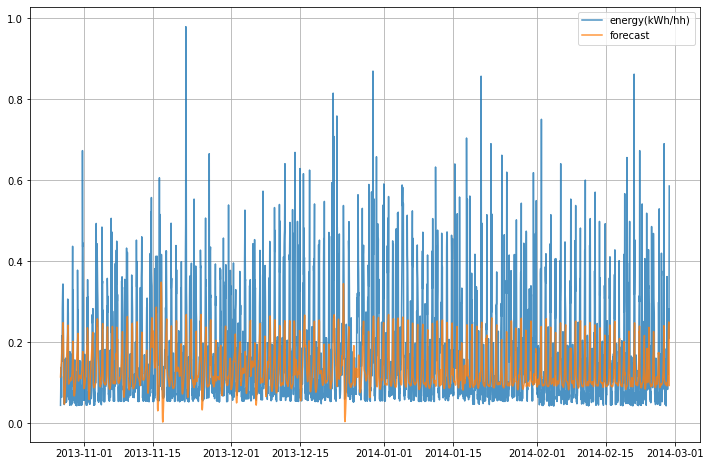

In [20]:
# Defining the lag that we used for training of the model 
lag_model = 24
# Getting the last period
ts = hh['energy(kWh/hh)'].tail(lag_model).values.tolist()
# Creating the X matrix for the model
#X, _ = DT.dc.create_X_Y(ts, lag=lag_model)

#for time values
tlist = hh['temperature'].tail(lag_model).values.tolist()
#print(tlist)
X, _ = LSTM.dc.create_X_Y(ts, tlist, lag=lag_model)
#print(X)

# Getting the forecast
yhat = LSTM.model.predict(X)

yhat = LSTM.predict()
# Constructing the forecast dataframe
fc = hh.tail(len(yhat)).copy()
fc.reset_index(inplace=True)
fc['forecast'] = yhat
# Ploting the forecasts
plt.figure(figsize=(12, 8))
for dtype in ['energy(kWh/hh)', 'forecast']:
  plt.plot(
    'tstp',
    dtype,
    data=fc,
    label=dtype,
    alpha=0.8
  )
plt.legend()
plt.grid()